# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import tensorflow as tf

warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
midfielder_df = fm_data_df[fm_data_df['포지션']=='미드필더']
midfielder_df = midfielder_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [3]:
num_col = [midfielder_df.columns[i] for i,x in enumerate(midfielder_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [4]:
midfielder_df.isna().sum()

이름              0
포지션             0
골               0
도움              0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
시즌              0
dtype: int64

## 변수 별 분포 확인

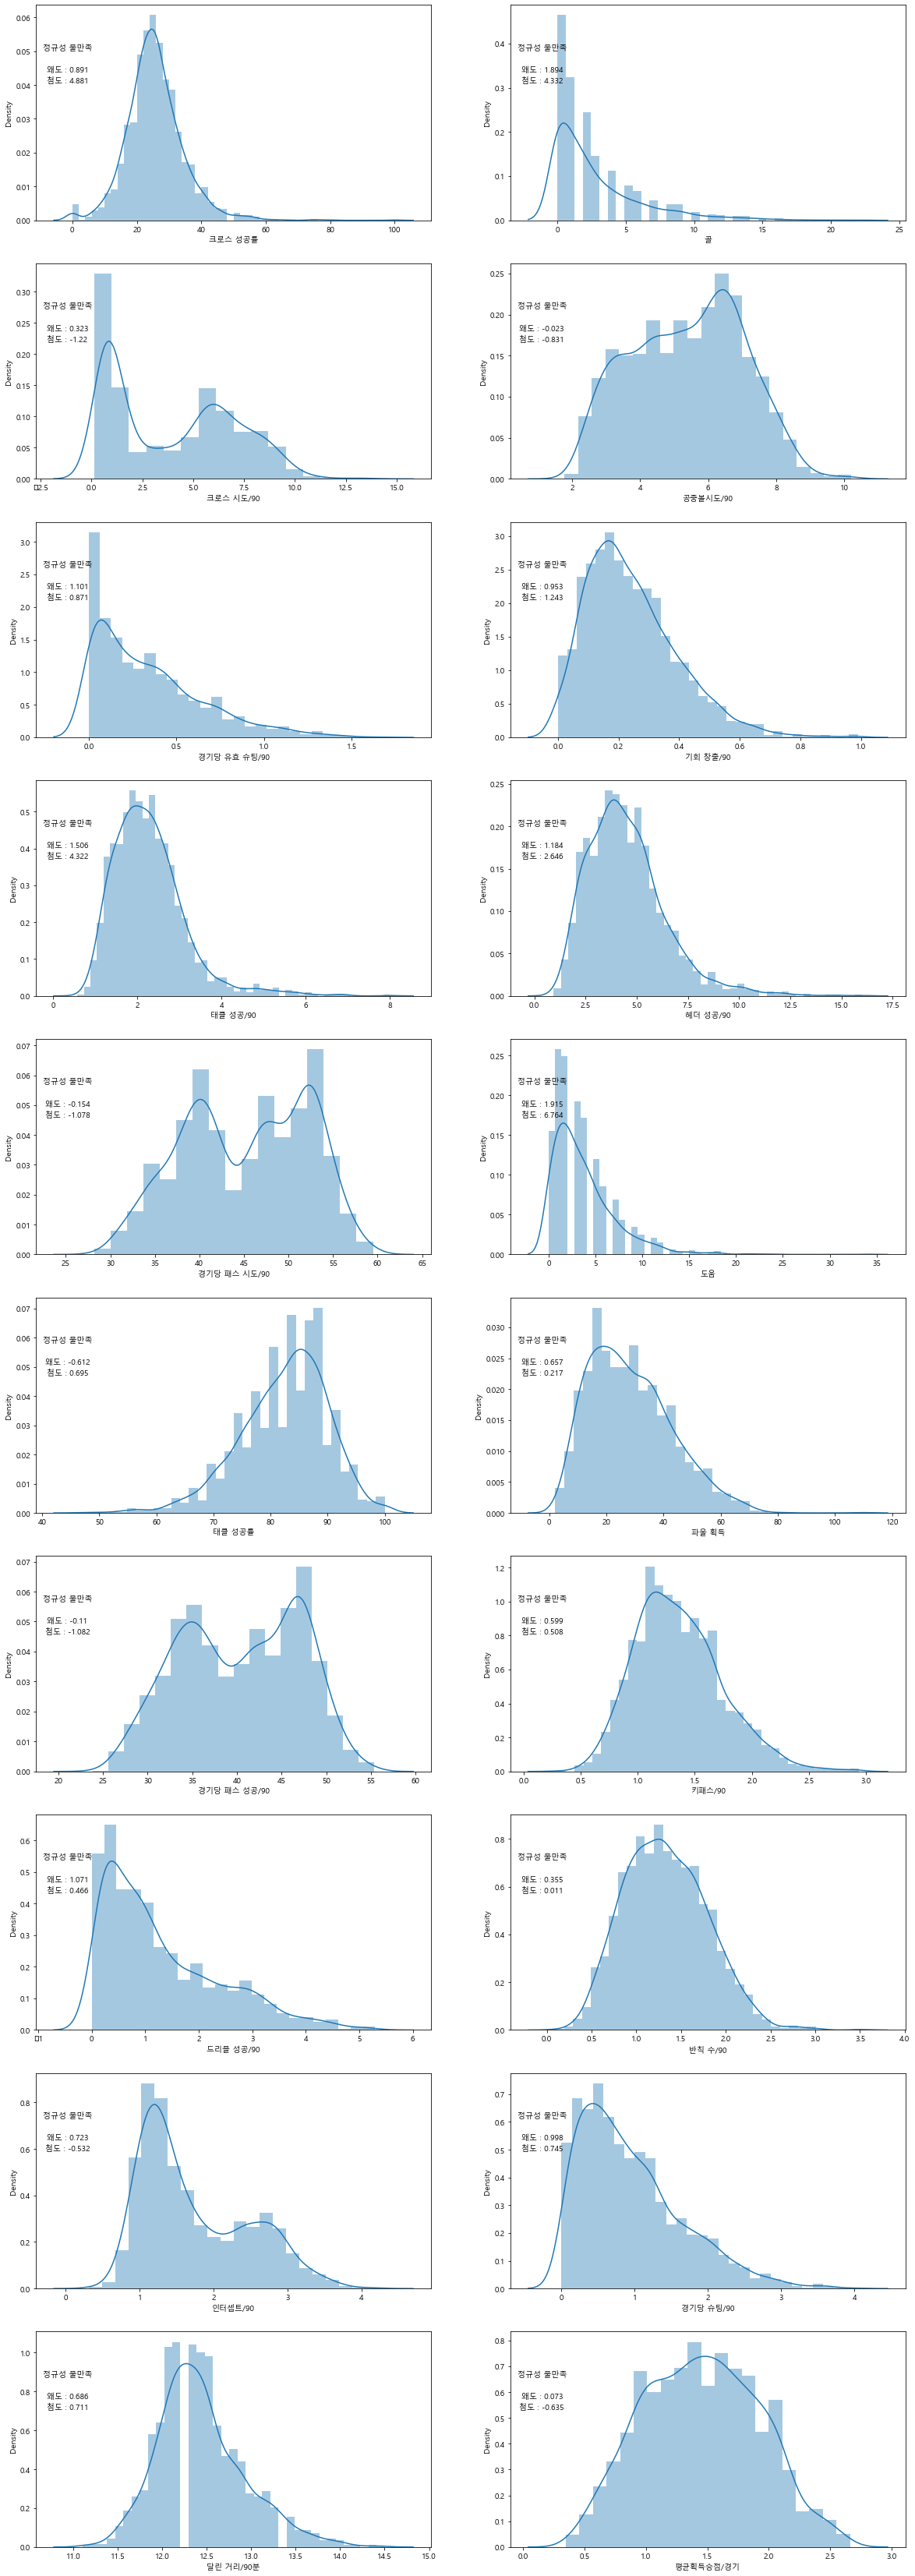

In [5]:
figs , axes = plt.subplots(10,2,figsize=(20,60))

for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    data = midfielder_df.loc[:,feature]
    sns.distplot(data,ax=ax)
    if stats.shapiro(data)[1]>= 0.05: 
        ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    skew = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    

last_ax = axes.ravel()[-1]
depen_data = midfielder_df.loc[:,dependent_value]
sns.distplot(depen_data,ax=last_ax)

if stats.shapiro(depen_data)[1]>= 0.05: 
    last_ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
else:
    last_ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
    
skew = stats.skew(depen_data)
kurtosis = stats.kurtosis(depen_data)
last_ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
last_ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)

plt.show()
plt.close()

모든 변수가 정규성 불만족 -> 정규화 필요

## 이상치 탐지

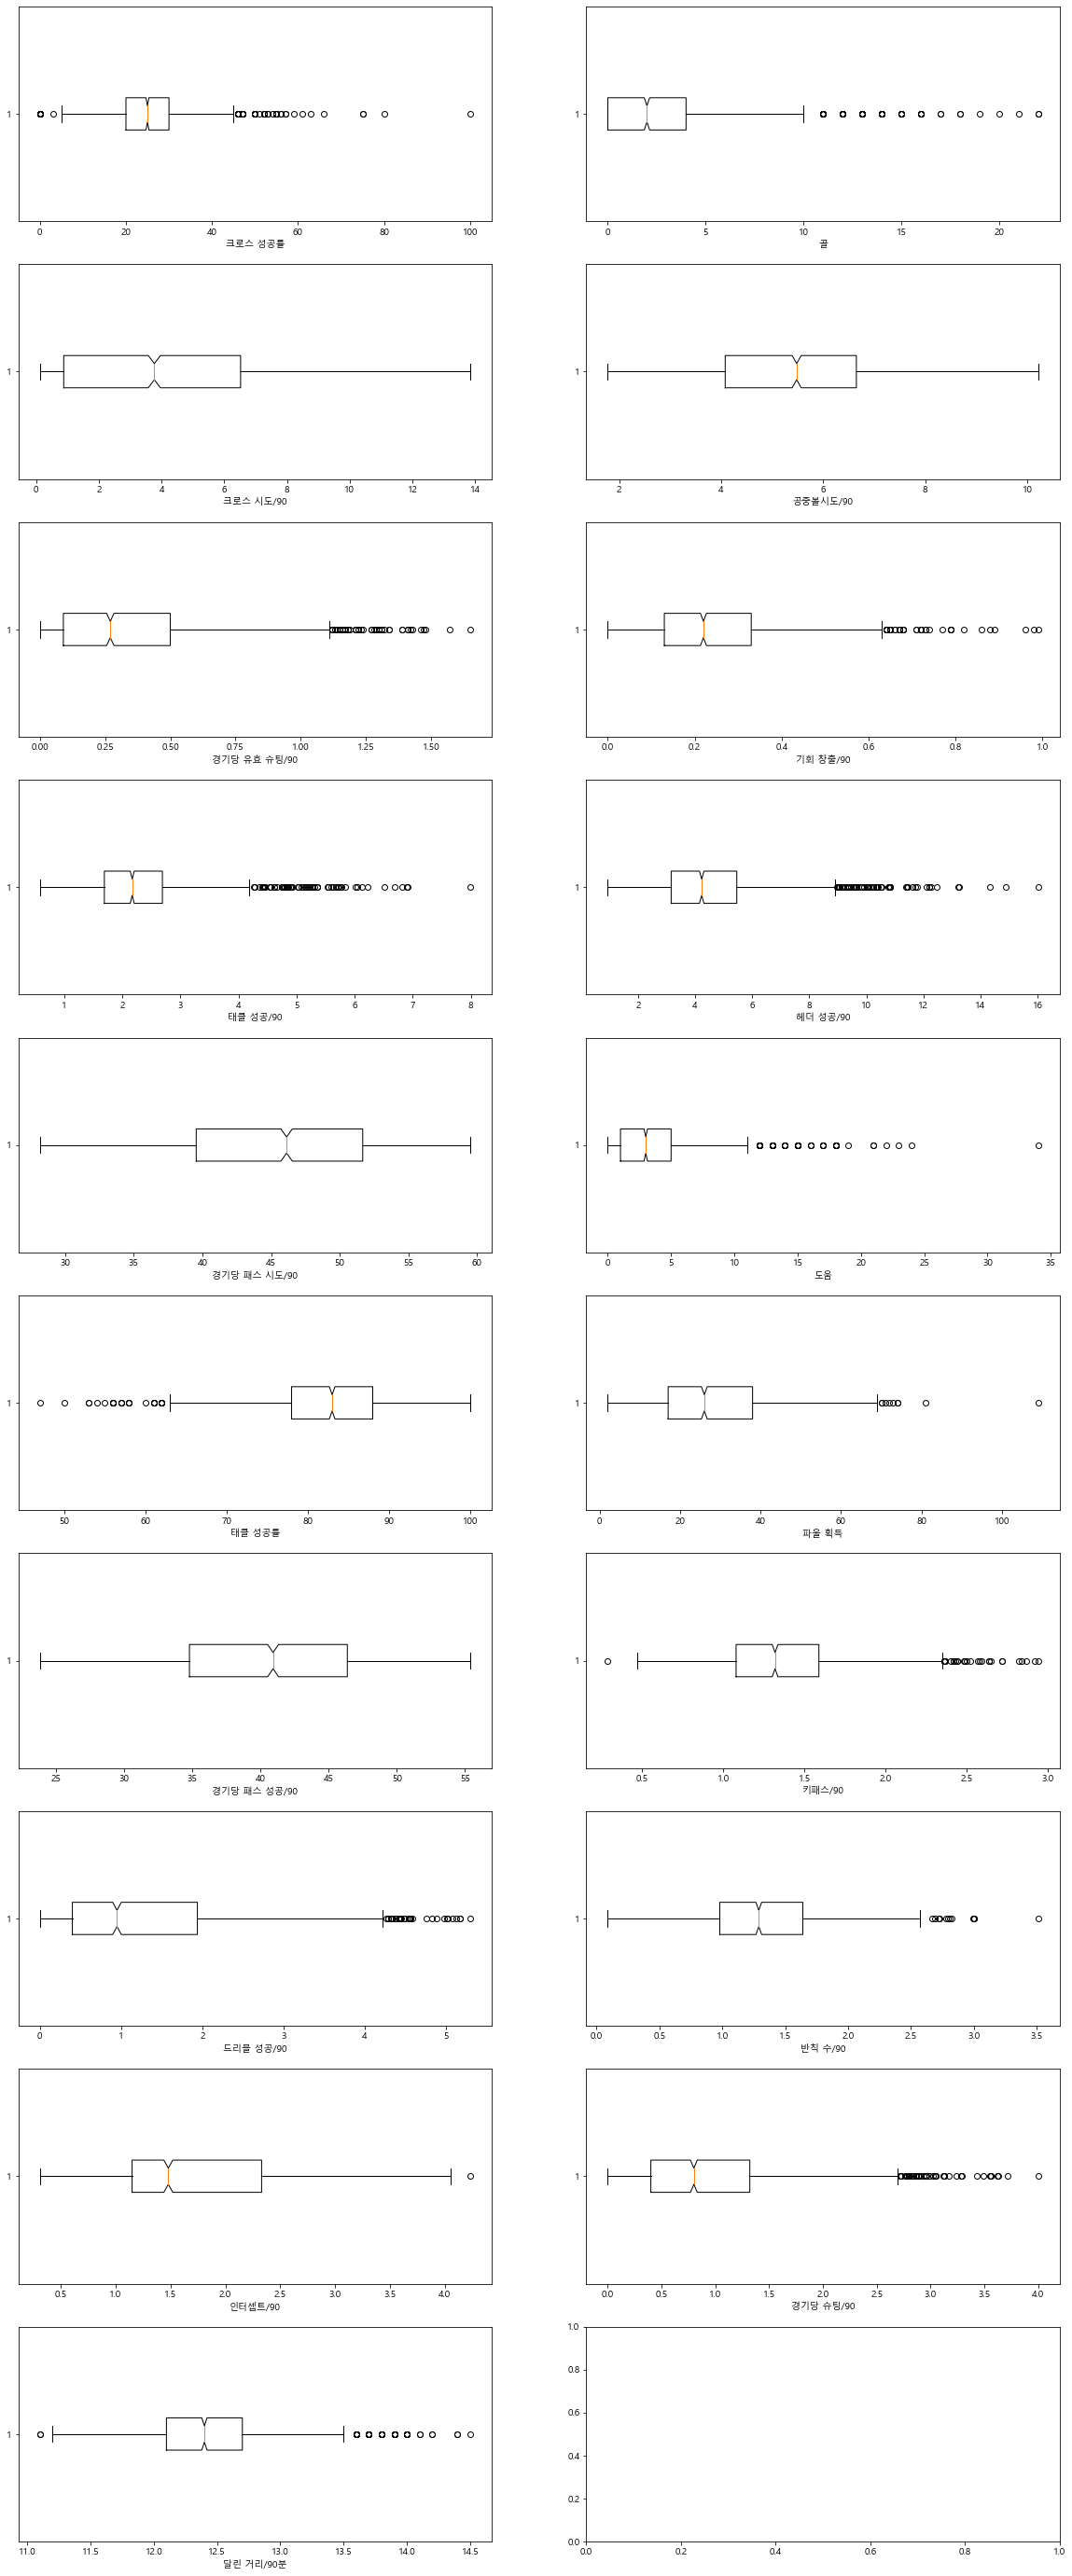

In [6]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),independent_value)) :
    ax.set_xlabel(feature)
    ax.boxplot(midfielder_df.loc[:,feature],notch=1,vert=0)
    
plt.show()

In [7]:
# 제거해야될 인덱스 셋
total = set([])

for feature in independent_value:
    
    data = midfielder_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    count = 0
    
    for i,v in enumerate(data):
        if v < low_bound or v > high_bound:
            count += 1
            total.add(i)
            
    print(f'{feature}중 이상치는 {count}개 비율은 약 {np.round(count/990*100,3)}% 입니다',end='\n\n')
    
print(f'이상치가 있는 row의 갯수는 총 {len(midfielder_df)}개의 데이터 중 {len(total)} 개 입니다.')

크로스 성공률중 이상치는 95개 비율은 약 9.596% 입니다

골중 이상치는 196개 비율은 약 19.798% 입니다

크로스 시도/90중 이상치는 0개 비율은 약 0.0% 입니다

공중볼시도/90중 이상치는 3개 비율은 약 0.303% 입니다

경기당 유효 슈팅/90중 이상치는 89개 비율은 약 8.99% 입니다

기회 창출/90중 이상치는 76개 비율은 약 7.677% 입니다

태클 성공/90중 이상치는 91개 비율은 약 9.192% 입니다

헤더 성공/90중 이상치는 88개 비율은 약 8.889% 입니다

경기당 패스 시도/90중 이상치는 0개 비율은 약 0.0% 입니다

도움중 이상치는 64개 비율은 약 6.465% 입니다

태클 성공률중 이상치는 43개 비율은 약 4.343% 입니다

파울 획득중 이상치는 41개 비율은 약 4.141% 입니다

경기당 패스 성공/90중 이상치는 0개 비율은 약 0.0% 입니다

키패스/90중 이상치는 55개 비율은 약 5.556% 입니다

드리블 성공/90중 이상치는 88개 비율은 약 8.889% 입니다

반칙 수/90중 이상치는 19개 비율은 약 1.919% 입니다

인터셉트/90중 이상치는 18개 비율은 약 1.818% 입니다

경기당 슈팅/90중 이상치는 80개 비율은 약 8.081% 입니다

달린 거리/90분중 이상치는 115개 비율은 약 11.616% 입니다

이상치가 있는 row의 갯수는 총 2093개의 데이터 중 767 개 입니다.


이상치를 제거한다면 데이터 손실이 너무 크다.

##  변수간 상관계수 분석 및 다중공선성 확인

### 상관계수

#### 상관계수 시각화

<AxesSubplot:>

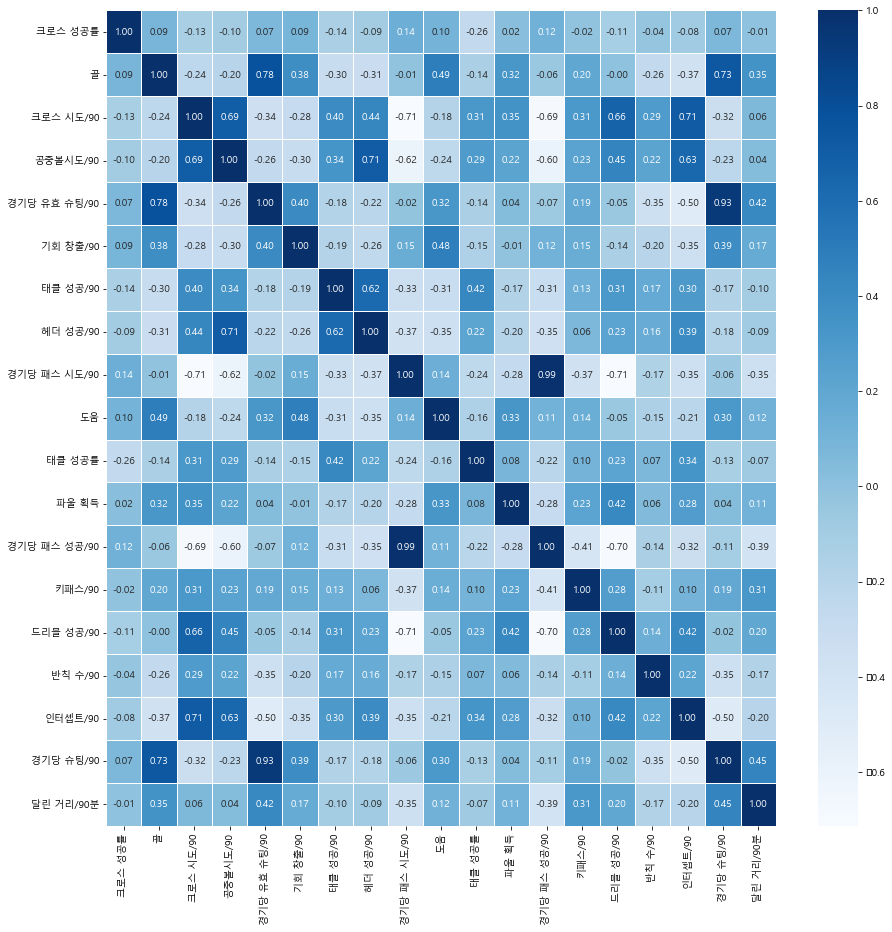

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap(data = midfielder_df.loc[:,independent_value].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

#### 종속변수 간 상관계수 , 독립변수와 상관계수

In [9]:
# 상관계수의 절대값이 0.7 이상인것들
high_corr_list = []
feature_comb = list(combinations(independent_value,2))
corr_dict_pair = {}

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for a,b in feature_comb:
    spearmann = spearmanr(midfielder_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
    if spearmann[0] >= 0.7 or spearmann[0] <= -0.7:
        high_corr_list.append([a,b,spearmann[0]])

pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

,변수 1,변수 2,상관계수
0,골,경기당 유효 슈팅/90,0.819230
1,골,경기당 슈팅/90,0.764536
2,크로스 시도/90,공중볼시도/90,0.707126
3,크로스 시도/90,경기당 패스 시도/90,-0.742012
4,크로스 시도/90,경기당 패스 성공/90,-0.723187
5,크로스 시도/90,드리블 성공/90,0.727636
6,크로스 시도/90,인터셉트/90,0.727543
7,공중볼시도/90,헤더 성공/90,0.775327
8,경기당 유효 슈팅/90,경기당 슈팅/90,0.934568
9,경기당 패스 시도/90,경기당 패스 성공/90,0.989445


In [10]:
corr_dict_dependent = {}
corr_list_dependent = []

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for val in independent_value:
    spearmann = spearmanr(midfielder_df[[val,dependent_value]])
    corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    corr_list_dependent.append([val,dependent_value,spearmann[0]])

pd.DataFrame(corr_list_dependent,columns=['종속변수','독립변수','상관계수'])

,종속변수,독립변수,상관계수
0,크로스 성공률,평균획득승점/경기,0.050474
1,골,평균획득승점/경기,0.247367
2,크로스 시도/90,평균획득승점/경기,-0.028066
3,공중볼시도/90,평균획득승점/경기,-0.123582
4,경기당 유효 슈팅/90,평균획득승점/경기,0.243839
5,기회 창출/90,평균획득승점/경기,0.181147
6,태클 성공/90,평균획득승점/경기,0.090830
7,헤더 성공/90,평균획득승점/경기,-0.009423
8,경기당 패스 시도/90,평균획득승점/경기,0.142030
9,도움,평균획득승점/경기,0.243386


### 다중공선성

In [11]:
this_vif = pd.DataFrame()
this_vif["VIF 계수"] = [vif(midfielder_df.loc[:,independent_value].values,i) for i in range(midfielder_df.loc[:,independent_value].values.shape[1])]
this_vif["종속변수"] = midfielder_df.loc[:,independent_value].columns
this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
this_vif

,VIF 계수,종속변수
0,3.934612,도움
1,5.545483,기회 창출/90
2,6.226849,드리블 성공/90
3,6.296970,골
4,10.146744,크로스 성공률
5,10.574344,파울 획득
6,11.376938,반칙 수/90
7,13.049894,크로스 시도/90
8,20.499931,키패스/90
9,20.750845,태클 성공/90


# 데이터 전처리

## 전처리 중간중간 쓰일 함수

In [12]:
def check_vif(independent_value):
    this_vif = pd.DataFrame()
    this_vif["VIF 계수"] = [vif(midfielder_df.loc[:,independent_value].values,i) for i in range(midfielder_df.loc[:,independent_value].values.shape[1])]
    this_vif["종속변수"] = midfielder_df.loc[:,independent_value].columns
    this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
    return this_vif

In [13]:
def check_indepen_high_corr(independent_value):
    # 상관계수의 절대값이 0.7 이상인것들
    high_corr_list = []
    feature_comb = list(combinations(independent_value,2))
    corr_dict_pair = {}

    # 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for a,b in feature_comb:
        spearmann = spearmanr(midfielder_df[[a,b]])
        corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
        if spearmann[0] >= 0.7 or spearmann[0] <= -0.7:
            high_corr_list.append([a,b,spearmann[0]])

    return pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

## 결측치 처리

결측치가 없음

## 다중공선성, 상관계수 처리 (기준: VIF >= 10 , 상관계수 > =+- 0.7) 및 처리

1. 골,경기당 슈팅, 유효 슈팅
2. 패스시도,패스성공
3. 키패스, 도움
3. 태클 성공률, 태클 성공/90
4. 공중볼 시도, 헤더성공
5. 드리블 시도
6. 인터셉트/90
7. 파울 획득
8. 반칙 수 /90
9. 달린거리/90분

### 골과 경기당 슈팅, 유효슈팅

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [14]:
midfielder_df[['골','경기당 유효 슈팅/90','경기당 슈팅/90','평균획득승점/경기']].corr()

,골,경기당 유효 슈팅/90,경기당 슈팅/90,평균획득승점/경기
골,1.000000,0.783450,0.734230,0.284689
경기당 유효 슈팅/90,0.783450,1.000000,0.934443,0.285186
경기당 슈팅/90,0.734230,0.934443,1.000000,0.257436
평균획득승점/경기,0.284689,0.285186,0.257436,1.000000


#### 피쳐 엔지니어링

In [15]:
# 0골인 선수 보정
midfielder_df['골'] = midfielder_df['골']+1
midfielder_df['경기당 슈팅/90'] = midfielder_df['경기당 슈팅/90']+1

In [16]:
# Shoot Accuracy Weighted Goal
midfielder_df['SAWG'] = (midfielder_df['경기당 유효 슈팅/90']*1.2 / midfielder_df['경기당 슈팅/90'])*midfielder_df['골']

independent_value.add('SAWG')
independent_value = independent_value - set(['골','경기당 슈팅/90','경기당 유효 슈팅/90'])

midfielder_df[['이름','SAWG']].sort_values(by='SAWG',ascending=False).head()

,이름,SAWG
1169,João Félix,10.740566
154,Nabil Fekir,8.869841
1970,Kai Havertz,8.280000
1170,Bernardo Silva,7.666667
1129,Neymar,7.636364


#### 상관계수 확인 (통과)

In [17]:
midfielder_df[['SAWG','평균획득승점/경기']].corr()

,SAWG,평균획득승점/경기
SAWG,1.000000,0.295392
평균획득승점/경기,0.295392,1.000000


### 경기당 패스시도, 패스성공

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균(0.25)보다 높은 피쳐를 만들자)

In [18]:
midfielder_df[['경기당 패스 성공/90','경기당 패스 시도/90','평균획득승점/경기']].corr()

,경기당 패스 성공/90,경기당 패스 시도/90,평균획득승점/경기
경기당 패스 성공/90,1.000000,0.991282,0.127664
경기당 패스 시도/90,0.991282,1.000000,0.141526
평균획득승점/경기,0.127664,0.141526,1.000000


In [19]:
midfielder_df[['이름','경기당 패스 시도/90']].sort_values(by="경기당 패스 시도/90",ascending=False).head()

,이름,경기당 패스 시도/90
890,Frenkie de Jong,59.49
359,Otávio,59.30
705,Lucas Torreira,59.24
1166,Kalvin Phillips,59.14
1620,Nico,59.10


#### 피쳐 엔지니어링

In [20]:
# Pass Weighted Accuracy
midfielder_df['PWA'] = ((midfielder_df['경기당 패스 성공/90'] / midfielder_df['경기당 패스 시도/90'])) + (midfielder_df['경기당 패스 시도/90']*0.8)

independent_value.add('PWA')
independent_value = independent_value - set(['경기당 패스 시도/90','경기당 패스 성공/90'])

midfielder_df[['이름','PWA']].sort_values(by='PWA',ascending=False).head()

,이름,PWA
890,Frenkie de Jong,48.522913
359,Otávio,48.369174
705,Lucas Torreira,48.315025
1166,Kalvin Phillips,48.236924
1620,Nico,48.177631


#### 상관계수 확인 (통과)

In [21]:
midfielder_df[['PWA','평균획득승점/경기']].corr()

,PWA,평균획득승점/경기
PWA,1.000000,0.141216
평균획득승점/경기,0.141216,1.000000


#### 다중 공선성 재확인

In [22]:
check_vif(independent_value)

,VIF 계수,종속변수
0,2.794340,SAWG
1,3.843061,도움
2,5.481476,기회 창출/90
3,6.176829,드리블 성공/90
4,10.004622,크로스 성공률
5,10.105192,파울 획득
6,10.989713,반칙 수/90
7,12.583119,크로스 시도/90
8,18.924993,키패스/90
9,20.569107,태클 성공/90


### 도움,키패스

In [23]:
midfielder_df[['도움','키패스/90','평균획득승점/경기']].corr()

,도움,키패스/90,평균획득승점/경기
도움,1.000000,0.144145,0.285406
키패스/90,0.144145,1.000000,0.068874
평균획득승점/경기,0.285406,0.068874,1.000000


In [24]:
# 0도움인 선수 보정
midfielder_df['도움'] = midfielder_df['도움'] + 0.1

In [25]:
# Assist Per KeyPass
midfielder_df['APK'] = (midfielder_df['도움'] / midfielder_df['키패스/90']) + midfielder_df['키패스/90']

independent_value.add('APK')
independent_value = independent_value - set(['도움','키패스/90'])

midfielder_df[['이름','APK']].sort_values(by='APK',ascending=False).head()

,이름,APK
1174,Kevin De Bruyne,25.120556
1376,Dejan Kulusevski,23.394815
547,N'Golo Kanté,19.196977
1872,Kevin De Bruyne,17.482308
750,Leon Goretzka,16.569856


In [26]:
midfielder_df[['APK','평균획득승점/경기']].corr()

,APK,평균획득승점/경기
APK,1.00000,0.26402
평균획득승점/경기,0.26402,1.00000


### 태클 성공률, 태클 성공/90

#### 태클 성공률, 태클 성공/90 제거 -> 90분당 태클 시도 생성

In [27]:
midfielder_df['태클 시도/90'] = midfielder_df['태클 성공/90']/midfielder_df['태클 성공률']

In [28]:
midfielder_df[['태클 시도/90','태클 성공/90','태클 성공률','평균획득승점/경기']].corr()

,태클 시도/90,태클 성공/90,태클 성공률,평균획득승점/경기
태클 시도/90,1.000000,0.968945,0.203404,0.107282
태클 성공/90,0.968945,1.000000,0.424749,0.090052
태클 성공률,0.203404,0.424749,1.000000,-0.030541
평균획득승점/경기,0.107282,0.090052,-0.030541,1.000000


In [29]:
midfielder_df['태클'] = (midfielder_df['태클 성공/90'])+(midfielder_df['태클 시도/90']) - (midfielder_df['태클 성공률']/100)
midfielder_df[['태클','평균획득승점/경기']].corr()

,태클,평균획득승점/경기
태클,1.000000,0.096213
평균획득승점/경기,0.096213,1.000000


In [30]:
independent_value.add('태클 시도/90')
independent_value.add('태클')
independent_value = independent_value-set(['태클 성공률','태클 성공/90' ,'태클 시도/90'])
check_vif(independent_value)

,VIF 계수,종속변수
0,2.731421,SAWG
1,5.275011,기회 창출/90
2,6.146492,드리블 성공/90
3,6.353810,APK
4,8.673763,태클
5,9.588203,크로스 성공률
6,9.937902,파울 획득
7,10.727041,반칙 수/90
8,12.307640,크로스 시도/90
9,20.399303,인터셉트/90


### 공중볼시도/90, 헤더 성공/90

#### 공중볼시도/90 헤더 성공/90 -> 피쳐 엔지니어링

In [31]:
midfielder_df[['공중볼시도/90','헤더 성공/90','평균획득승점/경기']].corr()

,공중볼시도/90,헤더 성공/90,평균획득승점/경기
공중볼시도/90,1.000000,0.708400,-0.129782
헤더 성공/90,0.708400,1.000000,-0.016743
평균획득승점/경기,-0.129782,-0.016743,1.000000


In [32]:
midfielder_df['헤더'] = (midfielder_df['공중볼시도/90'])+(midfielder_df['헤더 성공/90'])
midfielder_df[['헤더','평균획득승점/경기']].corr()

,헤더,평균획득승점/경기
헤더,1.000000,-0.074541
평균획득승점/경기,-0.074541,1.000000


헤더는 선수의 체격조건을 고려할 수 없기 때문에 공중볼에 대한 피쳐는 제거하기로 결정

In [33]:
independent_value = independent_value - set(['공중볼시도/90','헤더 성공/90'])
check_vif(independent_value)

,VIF 계수,종속변수
0,2.730061,SAWG
1,5.249937,기회 창출/90
2,5.807613,태클
3,6.008549,드리블 성공/90
4,6.340417,APK
5,9.001217,파울 획득
6,9.576812,크로스 성공률
7,10.647286,반칙 수/90
8,12.035629,크로스 시도/90
9,17.144179,인터셉트/90


### 드리블 성공

#### 종속변수와 상관계수 확인

In [34]:
midfielder_df[['드리블 성공/90','평균획득승점/경기']].corr()

,드리블 성공/90,평균획득승점/경기
드리블 성공/90,1.000000,0.065152
평균획득승점/경기,0.065152,1.000000


#### 독립변수 간 상관계수 확인

In [35]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수
0,크로스 시도/90,드리블 성공/90,0.727636
1,크로스 시도/90,인터셉트/90,0.727543
2,크로스 시도/90,PWA,-0.741538
3,드리블 성공/90,PWA,-0.788136


In [36]:
midfielder_df[['크로스 시도/90','평균획득승점/경기']].corr()

,크로스 시도/90,평균획득승점/경기
크로스 시도/90,1.00000,-0.03371
평균획득승점/경기,-0.03371,1.00000


In [37]:
midfielder_df[['인터셉트/90','평균획득승점/경기']].corr()

,인터셉트/90,평균획득승점/경기
인터셉트/90,1.000000,-0.052448
평균획득승점/경기,-0.052448,1.000000


종속변수에 영향이 적은 인터셉트 제거, 크로스 시도 제거를 통해 해결

In [38]:
independent_value = independent_value - set(['크로스 시도/90','PWA'])

In [39]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수


In [40]:
check_vif(independent_value)

,VIF 계수,종속변수
0,2.574564,SAWG
1,3.858590,드리블 성공/90
2,5.248967,기회 창출/90
3,5.632008,태클
4,6.086507,APK
5,8.778388,파울 획득
6,9.424591,크로스 성공률
7,10.326421,반칙 수/90
8,11.035625,인터셉트/90
9,34.328198,달린 거리/90분


### 파울 획득, 반칙 수

상관계수가 0.7 보다 높고 VIF가 10보다 높기 떄문에 기준에 벗어나지만 모델생성후 변수에 대해 다시 고려하기로 함

### 달린 거리/90

VIF가 너무 높기 때문에 삭제결정

In [41]:
independent_value= independent_value - set(['달린 거리/90분'])

### 최종 종속변수

In [42]:
independent_value

{'APK',
 'SAWG',
 '기회 창출/90',
 '드리블 성공/90',
 '반칙 수/90',
 '인터셉트/90',
 '크로스 성공률',
 '태클',
 '파울 획득'}

In [43]:
midfielder_df.columns

Index(['이름', '포지션', '골', '도움', '경기당 팀 득점/90', '경기당 팀 실점/90', '크로스 성공률',
       '파울 획득', '반칙 수/90', '기회 창출/90', '경기당 유효 슈팅/90', '경기당 슈팅/90', '인터셉트/90',
       '달린 거리/90분', '공중볼시도/90', '태클 성공률', '경기당 패스 시도/90', '경기당 패스 성공/90',
       '키패스/90', '태클 성공/90', '드리블 성공/90', '헤더 성공/90', '크로스 시도/90', '평균획득승점/경기',
       '시즌', 'SAWG', 'PWA', 'APK', '태클 시도/90', '태클', '헤더'],
      dtype='object')

## 이상치 처리

이상치를 제외하면 데이터 손실이 너무 크기 때문에 Quantile transform을 사용해서 이상치를 고려한 normalization을 진행하기로 함.

## 데이터 정규화

### 독립변수,종속변수 정규화

In [44]:
# 데이터의 2/3 수준의 quantile 적용

midfielder_qt = QuantileTransformer(n_quantiles=500).fit(midfielder_df.loc[:,independent_value])
midfielder_df.loc[:,independent_value] = midfielder_qt.transform(midfielder_df.loc[:,independent_value])

In [45]:
independent_value

{'APK',
 'SAWG',
 '기회 창출/90',
 '드리블 성공/90',
 '반칙 수/90',
 '인터셉트/90',
 '크로스 성공률',
 '태클',
 '파울 획득'}

In [46]:
fx_train,fx_test,fy_train,fy_test = train_test_split(midfielder_df.loc[:,independent_value],midfielder_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [47]:
inputs_layer = Input(shape=(len(independent_value),))
hidden1 = Dense(32,activation='relu',kernel_regularizer=L2(l2=0.02))(inputs_layer)
hidden2 = Dense(16,activation='relu',kernel_regularizer=L2(l2=0.02))(hidden1)
hidden3 = Dense(8,activation='relu')(hidden2)
output = Dense(1,activation='linear')(hidden3)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.001))
     
model.fit(fx_train,fy_train,batch_size=70,epochs=500,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)
mae

Epoch 1/500
24/24 [==============================] - 1s 10ms/step - loss: 2.2701 - val_loss: 1.7301
Epoch 2/500
24/24 [==============================] - 0s 4ms/step - loss: 1.3101 - val_loss: 0.9264
Epoch 3/500
24/24 [==============================] - 0s 3ms/step - loss: 0.8663 - val_loss: 0.7970
Epoch 4/500
24/24 [==============================] - 0s 3ms/step - loss: 0.7790 - val_loss: 0.7199
Epoch 5/500
24/24 [==============================] - 0s 3ms/step - loss: 0.7103 - val_loss: 0.6575
Epoch 6/500
24/24 [==============================] - 0s 3ms/step - loss: 0.6507 - val_loss: 0.6041
Epoch 7/500
24/24 [==============================] - 0s 4ms/step - loss: 0.5991 - val_loss: 0.5576
Epoch 8/500
24/24 [==============================] - 0s 4ms/step - loss: 0.5543 - val_loss: 0.5166
Epoch 9/500
24/24 [==============================] - 0s 4ms/step - loss: 0.5154 - val_loss: 0.4814
Epoch 10/500
24/24 [==============================] - 0s 4ms/step - loss: 0.4821 - val_loss: 0.4512
Epoch 11

24/24 [==============================] - 0s 3ms/step - loss: 0.2071 - val_loss: 0.1979
Epoch 84/500
24/24 [==============================] - 0s 3ms/step - loss: 0.2057 - val_loss: 0.1980
Epoch 85/500
24/24 [==============================] - 0s 3ms/step - loss: 0.2051 - val_loss: 0.1986
Epoch 86/500
24/24 [==============================] - 0s 3ms/step - loss: 0.2053 - val_loss: 0.1974
Epoch 87/500
24/24 [==============================] - 0s 3ms/step - loss: 0.2057 - val_loss: 0.1972
Epoch 88/500
24/24 [==============================] - 0s 3ms/step - loss: 0.2050 - val_loss: 0.1977
Epoch 89/500
24/24 [==============================] - 0s 3ms/step - loss: 0.2046 - val_loss: 0.1978
Epoch 90/500
24/24 [==============================] - 0s 4ms/step - loss: 0.2044 - val_loss: 0.1977
Epoch 91/500
24/24 [==============================] - 0s 3ms/step - loss: 0.2050 - val_loss: 0.1970
Epoch 92/500
24/24 [==============================] - 0s 3ms/step - loss: 0.2040 - val_loss: 0.1969
Epoch 93/500


24/24 [==============================] - 0s 3ms/step - loss: 0.1975 - val_loss: 0.1868
Epoch 165/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1951 - val_loss: 0.1866
Epoch 166/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1950 - val_loss: 0.1870
Epoch 167/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1945 - val_loss: 0.1860
Epoch 168/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1967 - val_loss: 0.1860
Epoch 169/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1949 - val_loss: 0.1860
Epoch 170/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1947 - val_loss: 0.1859
Epoch 171/500
24/24 [==============================] - 0s 3ms/step - loss: 0.1954 - val_loss: 0.1865
Epoch 172/500
24/24 [==============================] - 0s 3ms/step - loss: 0.1964 - val_loss: 0.1895
Epoch 173/500
24/24 [==============================] - 0s 3ms/step - loss: 0.1974 - val_loss: 0.1866
Epoc

24/24 [==============================] - 0s 4ms/step - loss: 0.1912 - val_loss: 0.1880
Epoch 246/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1928 - val_loss: 0.1826
Epoch 247/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1912 - val_loss: 0.1839
Epoch 248/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1903 - val_loss: 0.1818
Epoch 249/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1910 - val_loss: 0.1821
Epoch 250/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1917 - val_loss: 0.1816
Epoch 251/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1913 - val_loss: 0.1818
Epoch 252/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1906 - val_loss: 0.1817
Epoch 253/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1904 - val_loss: 0.1869
Epoch 254/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1917 - val_loss: 0.1834
Epoc

24/24 [==============================] - 0s 5ms/step - loss: 0.1884 - val_loss: 0.1796
Epoch 327/500
24/24 [==============================] - 0s 5ms/step - loss: 0.1881 - val_loss: 0.1802
Epoch 328/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1891 - val_loss: 0.1902
Epoch 329/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1883 - val_loss: 0.1798
Epoch 330/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1879 - val_loss: 0.1842
Epoch 331/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1881 - val_loss: 0.1800
Epoch 332/500
24/24 [==============================] - 0s 7ms/step - loss: 0.1880 - val_loss: 0.1794
Epoch 333/500
24/24 [==============================] - 0s 6ms/step - loss: 0.1877 - val_loss: 0.1795
Epoch 334/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1884 - val_loss: 0.1819
Epoch 335/500
24/24 [==============================] - 0s 5ms/step - loss: 0.1906 - val_loss: 0.1795
Epoc

24/24 [==============================] - 0s 3ms/step - loss: 0.1872 - val_loss: 0.1796
Epoch 408/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1880 - val_loss: 0.1788
Epoch 409/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1877 - val_loss: 0.1794
Epoch 410/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1889 - val_loss: 0.1793
Epoch 411/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1875 - val_loss: 0.1802
Epoch 412/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1874 - val_loss: 0.1783
Epoch 413/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1878 - val_loss: 0.1796
Epoch 414/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1895 - val_loss: 0.1801
Epoch 415/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1875 - val_loss: 0.1797
Epoch 416/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1885 - val_loss: 0.1839
Epoc

24/24 [==============================] - 0s 4ms/step - loss: 0.1872 - val_loss: 0.1774
Epoch 489/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1859 - val_loss: 0.1775
Epoch 490/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1859 - val_loss: 0.1782
Epoch 491/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1863 - val_loss: 0.1773
Epoch 492/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1876 - val_loss: 0.1775
Epoch 493/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1860 - val_loss: 0.1784
Epoch 494/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1870 - val_loss: 0.1806
Epoch 495/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1921 - val_loss: 0.1870
Epoch 496/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1872 - val_loss: 0.1789
Epoch 497/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1875 - val_loss: 0.1779
Epoc

0.33943468300994656

## 변수선택법

In [48]:
from statsmodels.regression.linear_model import OLS

ols_model = OLS(fy_train,fx_train)
regr = ols_model.fit()
best_aic = regr.aic
best_aic

2180.07064327572

In [49]:
best_values = []

for i in range(len(independent_value)+1,1,-1):
    for var in list(combinations(independent_value,i)):
        ols_model = OLS(fy_train,fx_train.loc[:,var])
        regr = ols_model.fit()
        if best_aic<regr.aic:
            pass
        else:
            best_aic = regr.aic
            best_values = var
best_values

('SAWG', '크로스 성공률', '태클', '반칙 수/90', '인터셉트/90', '기회 창출/90', '파울 획득', 'APK')

In [50]:
best_aic

2178.098574935362

In [51]:
independent_value = best_values

In [52]:
fx_train,fx_test,fy_train,fy_test = train_test_split(midfielder_df.loc[:,independent_value],midfielder_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [53]:
inputs_layer = Input(shape=(len(independent_value),))
hidden1 = Dense(64,activation='relu',kernel_regularizer=L2(l2=0.01))(inputs_layer)
hidden2 = Dense(32,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden1)
hidden3 = Dense(16,activation='relu')(hidden2)
output = Dense(1,activation='linear')(hidden3)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.0005))
     
model.fit(fx_train,fy_train,batch_size=120,epochs=500,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)
mae

Epoch 1/500
14/14 [==============================] - 1s 25ms/step - loss: 2.6665 - val_loss: 2.4265
Epoch 2/500
14/14 [==============================] - 0s 4ms/step - loss: 2.2213 - val_loss: 1.9988
Epoch 3/500
14/14 [==============================] - 0s 4ms/step - loss: 1.8029 - val_loss: 1.5647
Epoch 4/500
14/14 [==============================] - 0s 4ms/step - loss: 1.3731 - val_loss: 1.1303
Epoch 5/500
14/14 [==============================] - 0s 4ms/step - loss: 0.9860 - val_loss: 0.8087
Epoch 6/500
14/14 [==============================] - 0s 4ms/step - loss: 0.7771 - val_loss: 0.7186
Epoch 7/500
14/14 [==============================] - 0s 4ms/step - loss: 0.7360 - val_loss: 0.6982
Epoch 8/500
14/14 [==============================] - 0s 4ms/step - loss: 0.7092 - val_loss: 0.6727
Epoch 9/500
14/14 [==============================] - 0s 4ms/step - loss: 0.6872 - val_loss: 0.6525
Epoch 10/500
14/14 [==============================] - 0s 4ms/step - loss: 0.6664 - val_loss: 0.6321
Epoch 11

14/14 [==============================] - 0s 4ms/step - loss: 0.2444 - val_loss: 0.2350
Epoch 84/500
14/14 [==============================] - 0s 4ms/step - loss: 0.2442 - val_loss: 0.2361
Epoch 85/500
14/14 [==============================] - 0s 4ms/step - loss: 0.2404 - val_loss: 0.2325
Epoch 86/500
14/14 [==============================] - 0s 4ms/step - loss: 0.2400 - val_loss: 0.2323
Epoch 87/500
14/14 [==============================] - 0s 4ms/step - loss: 0.2386 - val_loss: 0.2303
Epoch 88/500
14/14 [==============================] - 0s 4ms/step - loss: 0.2385 - val_loss: 0.2294
Epoch 89/500
14/14 [==============================] - 0s 4ms/step - loss: 0.2376 - val_loss: 0.2306
Epoch 90/500
14/14 [==============================] - 0s 4ms/step - loss: 0.2352 - val_loss: 0.2280
Epoch 91/500
14/14 [==============================] - 0s 4ms/step - loss: 0.2349 - val_loss: 0.2290
Epoch 92/500
14/14 [==============================] - 0s 4ms/step - loss: 0.2337 - val_loss: 0.2252
Epoch 93/500


14/14 [==============================] - 0s 6ms/step - loss: 0.1997 - val_loss: 0.1943
Epoch 165/500
14/14 [==============================] - 0s 5ms/step - loss: 0.1997 - val_loss: 0.1937
Epoch 166/500
14/14 [==============================] - 0s 4ms/step - loss: 0.2010 - val_loss: 0.1924
Epoch 167/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1993 - val_loss: 0.1922
Epoch 168/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1990 - val_loss: 0.1939
Epoch 169/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1992 - val_loss: 0.1930
Epoch 170/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1985 - val_loss: 0.1919
Epoch 171/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1981 - val_loss: 0.1920
Epoch 172/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1988 - val_loss: 0.1916
Epoch 173/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1980 - val_loss: 0.1911
Epoc

14/14 [==============================] - 0s 5ms/step - loss: 0.1918 - val_loss: 0.1931
Epoch 246/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1923 - val_loss: 0.1853
Epoch 247/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1911 - val_loss: 0.1852
Epoch 248/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1907 - val_loss: 0.1872
Epoch 249/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1906 - val_loss: 0.1862
Epoch 250/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1914 - val_loss: 0.1856
Epoch 251/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1916 - val_loss: 0.1915
Epoch 252/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1923 - val_loss: 0.1861
Epoch 253/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1923 - val_loss: 0.1845
Epoch 254/500
14/14 [==============================] - 0s 5ms/step - loss: 0.1913 - val_loss: 0.1845
Epoc

14/14 [==============================] - 0s 4ms/step - loss: 0.1860 - val_loss: 0.1819
Epoch 327/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1864 - val_loss: 0.1816
Epoch 328/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1855 - val_loss: 0.1841
Epoch 329/500
14/14 [==============================] - 0s 6ms/step - loss: 0.1876 - val_loss: 0.1813
Epoch 330/500
14/14 [==============================] - 0s 5ms/step - loss: 0.1862 - val_loss: 0.1825
Epoch 331/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1864 - val_loss: 0.1858
Epoch 332/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1870 - val_loss: 0.1836
Epoch 333/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1859 - val_loss: 0.1817
Epoch 334/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1858 - val_loss: 0.1868
Epoch 335/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1875 - val_loss: 0.1820
Epoc

14/14 [==============================] - 0s 8ms/step - loss: 0.1823 - val_loss: 0.1808
Epoch 408/500
14/14 [==============================] - 0s 7ms/step - loss: 0.1834 - val_loss: 0.1885
Epoch 409/500
14/14 [==============================] - 0s 9ms/step - loss: 0.1844 - val_loss: 0.1879
Epoch 410/500
14/14 [==============================] - 0s 10ms/step - loss: 0.1844 - val_loss: 0.1870
Epoch 411/500
14/14 [==============================] - 0s 6ms/step - loss: 0.1832 - val_loss: 0.1813
Epoch 412/500
14/14 [==============================] - 0s 7ms/step - loss: 0.1827 - val_loss: 0.1807
Epoch 413/500
14/14 [==============================] - 0s 8ms/step - loss: 0.1826 - val_loss: 0.1808
Epoch 414/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1827 - val_loss: 0.1811
Epoch 415/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1825 - val_loss: 0.1859
Epoch 416/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1822 - val_loss: 0.1821
Epo

14/14 [==============================] - 0s 4ms/step - loss: 0.1823 - val_loss: 0.1821
Epoch 489/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1837 - val_loss: 0.1855
Epoch 490/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1811 - val_loss: 0.1827
Epoch 491/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1808 - val_loss: 0.1844
Epoch 492/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1802 - val_loss: 0.1815
Epoch 493/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1795 - val_loss: 0.1813
Epoch 494/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1822 - val_loss: 0.1820
Epoch 495/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1799 - val_loss: 0.1852
Epoch 496/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1806 - val_loss: 0.1813
Epoch 497/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1796 - val_loss: 0.1807
Epoc

0.3396591840154516

In [54]:
with open('./models/midfielder_qt.pickle','wb') as f:
    pickle.dump(midfielder_qt,f)
model.save('./models/midfielder_nn.h5')

# 모델검정

In [55]:
midfielder_df['predict'] = model.predict(midfielder_df.loc[:,independent_value])

In [56]:
residual = midfielder_df['평균획득승점/경기'] - midfielder_df['predict']

## 선형성 검정

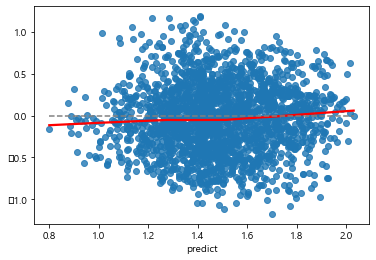

In [57]:
sns.regplot(midfielder_df['predict'], residual, lowess=True, line_kws={'color': 'red'})
plt.plot([midfielder_df['predict'].values.min(), midfielder_df['predict'].values.max()], [0, 0], '--', color='grey')

## 잔차의 정규성 검정

In [58]:
# 정규성 불만족
stats.shapiro(residual)

ShapiroResult(statistic=0.9968567490577698, pvalue=0.000272038159891963)

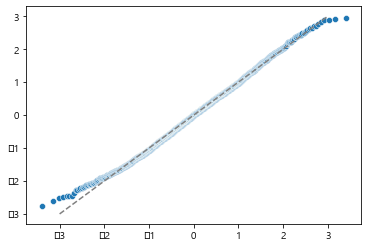

In [59]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

## 잔차의 등분산성 검정

<AxesSubplot:xlabel='predict'>

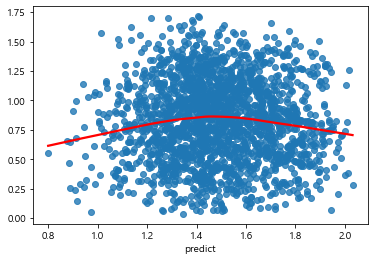

In [60]:
sns.regplot(midfielder_df['predict'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

In [61]:
# 등분산성 불만족
stats.levene(midfielder_df['평균획득승점/경기'],midfielder_df['predict'])

LeveneResult(statistic=1153.575965403374, pvalue=1.546625585929028e-223)